In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def preprocess(image_path):
    # Read and normalize image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256,256))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image/255.0 # Normalize to [0,1]

In [14]:
def trimmed_median_filter(image, window_size=3, d=2):
    # Convert float [0,1] to uint8 [0-255]
    image_uint8 = (image * 255).astype(np.uint8)
    # Apply padding and median filtering
    padded = cv2.copyMakeBorder(image_uint8, d, d, d, d, cv2.BORDER_REFLECT)
    filtered = cv2.medianBlur(padded, window_size)
    # Remove padding and convert back to float [0,1]
    return filtered[d:-d, d:-d].astype(np.float32) / 255.0

In [10]:
# Colore corection using gray world algorithm
def gray_world_balance(image):
    avg = np.mean(image, axis=(0,1))
    gray = np.mean(avg)
    scale = gray/avg
    return np.clip(image * scale, 0, 1)

In [26]:
# Contrast Enhancement using CLAHE
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)  # Convert to LAB color space
    l, a, b = cv2.split(lab)  # Split into L, A, B channels
    
    # Ensure L-channel is uint8
    l = np.clip(l, 0, 255).astype(np.uint8)
    
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # Ensure all channels have the same shape and type
    cl = cl.astype(np.uint8)
    a = a.astype(np.uint8)
    b = b.astype(np.uint8)

    lab = cv2.merge((cl, a, b))  # Merge processed L with A and B
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)  # Convert back to RGB

In [12]:
# Haze Removal using Laplacian Decomposition
def laplacian_haze_removal(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    laplacian = cv2.normalize(laplacian, None, 0, 1, cv2.NORM_MINMAX)
    enhanced = image - laplacian[..., np.newaxis] * 0.5  # Adjust haze strength
    return np.clip(enhanced, 0, 1)

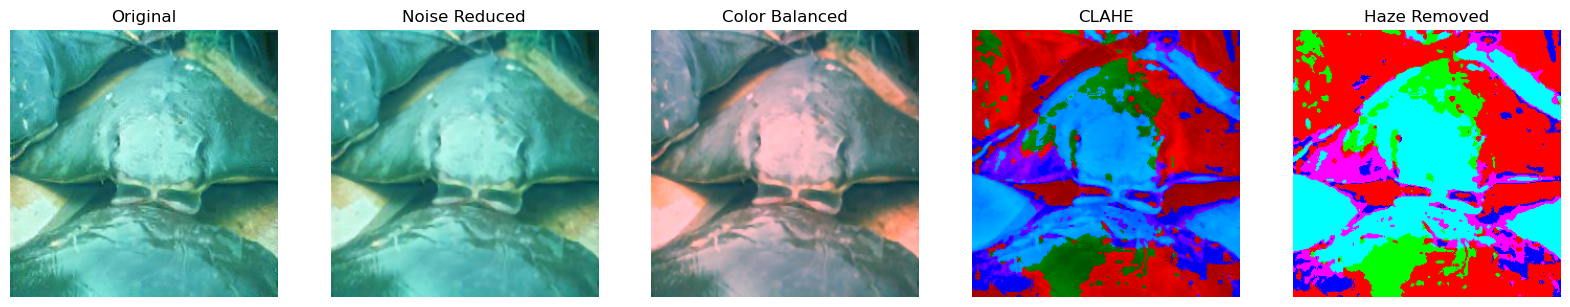

In [27]:
# Example usage
image = preprocess("dataset/Paired/underwater_imagenet/trainA/n01496331_49.jpg")
filtered = trimmed_median_filter(image)
color_balanced = gray_world_balance(filtered)
contrast_enhanced = apply_clahe(color_balanced)
final_image = laplacian_haze_removal(contrast_enhanced)

# Plot results
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
titles = ["Original", "Noise Reduced", "Color Balanced", "CLAHE", "Haze Removed"]
for ax, img, title in zip(axes, [image, filtered, color_balanced, contrast_enhanced, final_image], titles):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')
plt.show()